In [1]:
pip install pgmpy

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import HillClimbSearch, BicScore
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination


c:\Users\zhossai3\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
data = pd.read_csv(r'C:\Users\zhossai3\Desktop\My code\OT+Fairness\Data\German Credit\German_Credit_Ground_Truth.csv')


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Age               1000 non-null   int64  
 1   Sex               1000 non-null   int64  
 2   Job               1000 non-null   int64  
 3   Housing           1000 non-null   int64  
 4   Saving accounts   1000 non-null   float64
 5   Checking account  1000 non-null   float64
 6   Credit amount     1000 non-null   int64  
 7   Duration          1000 non-null   int64  
 8   Purpose           1000 non-null   int64  
 9   Risk              1000 non-null   int64  
dtypes: float64(2), int64(8)
memory usage: 78.3 KB


Learning the structure of the Bayesian Network...


  0%|          | 4/1000000 [00:00<22:50:27, 12.16it/s]


Bayesian Network Structure:
[('Housing', 'Sex'), ('Checking account', 'Risk'), ('Risk', 'Saving accounts'), ('Risk', 'Housing')]


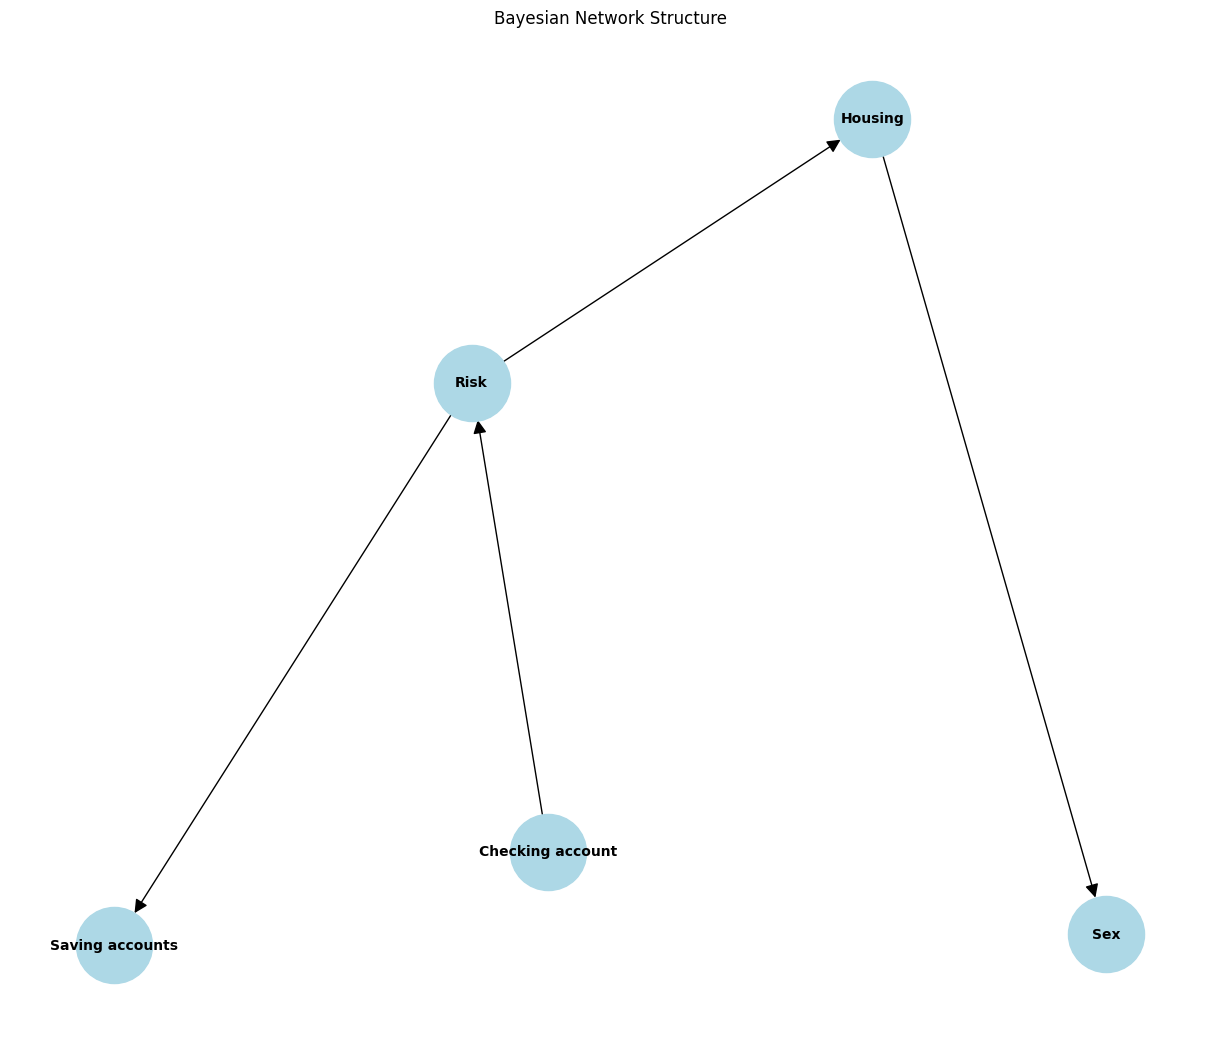

Fitting the Bayesian Network with data...


In [4]:



# Step 2: Identify missingness indicators
# Add missingness indicators for each column with missing values
missing_indicators = {}
for column in data.columns:
    if data[column].isnull().any():
        missing_indicators[f'R_{column}'] = data[column].isnull().astype(int)

# Add missingness indicators to the dataset
for key, value in missing_indicators.items():
    data[key] = value

# Drop rows with missing values temporarily for structure learning
data_complete = data.dropna()

# Step 3: Learn the structure of the Bayesian Network
print("Learning the structure of the Bayesian Network...")
hc = HillClimbSearch(data_complete)
model = hc.estimate(scoring_method=BicScore(data_complete))

# Create the Bayesian Network from the learned structure
bayesian_net = BayesianNetwork(model.edges())

# Step 4: Visualize the Bayesian Network
def visualize_bayesian_network(bayesian_net):
    # Create a networkx graph from the Bayesian Network
    G = nx.DiGraph()
    G.add_edges_from(bayesian_net.edges())

    # Plot the graph
    plt.figure(figsize=(12, 10))
    pos = nx.spring_layout(G)  # Define layout
    nx.draw(
        G,
        pos,
        with_labels=True,
        node_size=3000,
        node_color="lightblue",
        font_size=10,
        font_weight="bold",
        arrowsize=20,
    )
    plt.title("Bayesian Network Structure")
    plt.show()

print("Bayesian Network Structure:")
print(bayesian_net.edges())
visualize_bayesian_network(bayesian_net)

# Step 5: Fit the Bayesian Network with the data
print("Fitting the Bayesian Network with data...")
bayesian_net.fit(data, estimator=MaximumLikelihoodEstimator)


In [7]:
inference = VariableElimination(bayesian_net)

# Example Query 1: Probability of missingness for a variable
print("\nProbabilities of Missingness:")
for missing_var in missing_indicators.keys():
    query_result = inference.query(variables=[missing_var])
    print(f"{missing_var}:")
    print(query_result)

# Example Query 2: Joint probability of two variables
query_result = inference.query(variables=["Checking account", "Risk","Housing"])
print("\nJoint Probability")
print(query_result)



Probabilities of Missingness:

Joint Probability
+------------------------+---------+------------+--------------------------------------+
| Checking account       | Risk    | Housing    |   phi(Checking account,Risk,Housing) |
+========================+=========+============+======================================+
| Checking account(-1.0) | Risk(0) | Housing(0) |                               0.0067 |
+------------------------+---------+------------+--------------------------------------+
| Checking account(-1.0) | Risk(0) | Housing(1) |                               0.0285 |
+------------------------+---------+------------+--------------------------------------+
| Checking account(-1.0) | Risk(0) | Housing(2) |                               0.0107 |
+------------------------+---------+------------+--------------------------------------+
| Checking account(-1.0) | Risk(1) | Housing(0) |                               0.0318 |
+------------------------+---------+------------+-----------

In [8]:
result = inference.query(variables=["Housing"], evidence={"Risk": True})
print("Conditional Probability P(Housing | Risk = True):")
print(result)

Conditional Probability P(Housing | Risk = True):
+------------+----------------+
| Housing    |   phi(Housing) |
+============+================+
| Housing(0) |         0.0914 |
+------------+----------------+
| Housing(1) |         0.7529 |
+------------+----------------+
| Housing(2) |         0.1557 |
+------------+----------------+


In [9]:
for missing_var in missing_indicators.keys():
    query_result = inference.query(variables=[missing_var])
    print(f"{missing_var}:")
    print(query_result)
missing_indicators

{}

In [10]:
# Print nodes and edges
print("Nodes in the Bayesian Network:")
print(bayesian_net.nodes())

print("Edges in the Bayesian Network:")
print(bayesian_net.edges())


Nodes in the Bayesian Network:
['Housing', 'Sex', 'Checking account', 'Risk', 'Saving accounts']
Edges in the Bayesian Network:
[('Housing', 'Sex'), ('Checking account', 'Risk'), ('Risk', 'Saving accounts'), ('Risk', 'Housing')]
